# **INTRODUCTION TO AI**


---



> FA22-BAI-032 Muniba Manaal


## **Mid Term Project**

# **Game Selection:**

---


The game I have selected for this project is "Connect Four." It's a strategic decision-making game with well-defined rules. The game involves two players, where one tries to connect four pieces in a row either horizontally, vertically, or diagonally. The rules and objectives of Connect Four are understood.

## **Rules:**

Game Board: The game board consists of a 6x7 grid, with a total of 42 spaces.

1.   Two Players: Connect Four is played by two players, often referred to as Player 1 (with red pieces) and Player 2 (with yellow pieces).
2.   Alternate Turns: Players take turns dropping one of their colored discs from the top into any of the seven columns.

1.   Gravity: When a disc is dropped into a column, it falls to the lowest available space within that column. This simulates the effect of gravity.
2.   Winning Condition: The game is won by the first player who successfully forms a horizontal, vertical, or diagonal line of four of their own pieces. The line can be in any direction (up, down, left, right, or diagonally).

1.   Draw: If all 42 spaces on the board are filled and no player has formed a winning line, the game ends in a draw.



## **Objectives:**



1.   The primary objective in Connect Four is to be the first to form a line of four of your own pieces. This can be achieved either horizontally, vertically, or diagonally.
2.   Players must also pay attention to blocking their opponent from forming a line of four.

1.   Strategic thinking and planning are essential in this game. Players must consider their moves carefully to maximize their chances of winning while preventing their opponent from winning.
2.   The game encourages players to think ahead and anticipate their opponent's moves.

1.   The game ends when a player connects four of their pieces or when the board is filled with no winner, resulting in a draw.



Overall, the objectives in Connect Four are to create opportunities to connect four pieces while strategically blocking your opponent's attempts to do the same. It's a classic game that combines simplicity with strategic depth.

### **Applying Monte Carlo Algorithm**

## Monte Carlo Tree Search (MCTS)

---


We normally learn to play games by learning moves that lead to us winning or a high score. In terms of a machine agent learning how to play games there are a few options to choose from.

1.   Learn from the reward function
2.   Learn from knowing which states are inherently better

With Monte Carlo Tree Search, we use the second option to used to choose optimal moves to beat the game.

Intuition of MCTS

> One type of tree traversal algorithm that you may be familiar with is Depth First Search (DFS). For example, to beat a game using DFS, we would simulate every single possible outcome. If we can simulate every outcome, it is trivial to come up with the best action for each state. However, it is extremely computationally heavy to compute every single possible outcome.


In fact, there are over 10^120 different games of chess — more than the amount of atoms in the universe. With the world's fastest supercomputer being able to perform 10^18 floating-point operations per second, and reducing each
dfs() call to be one operation, it would at least take 10^102 seconds ≈ 10^95 years. Below is just one part of a tree for the simple game tic-tac-toe.
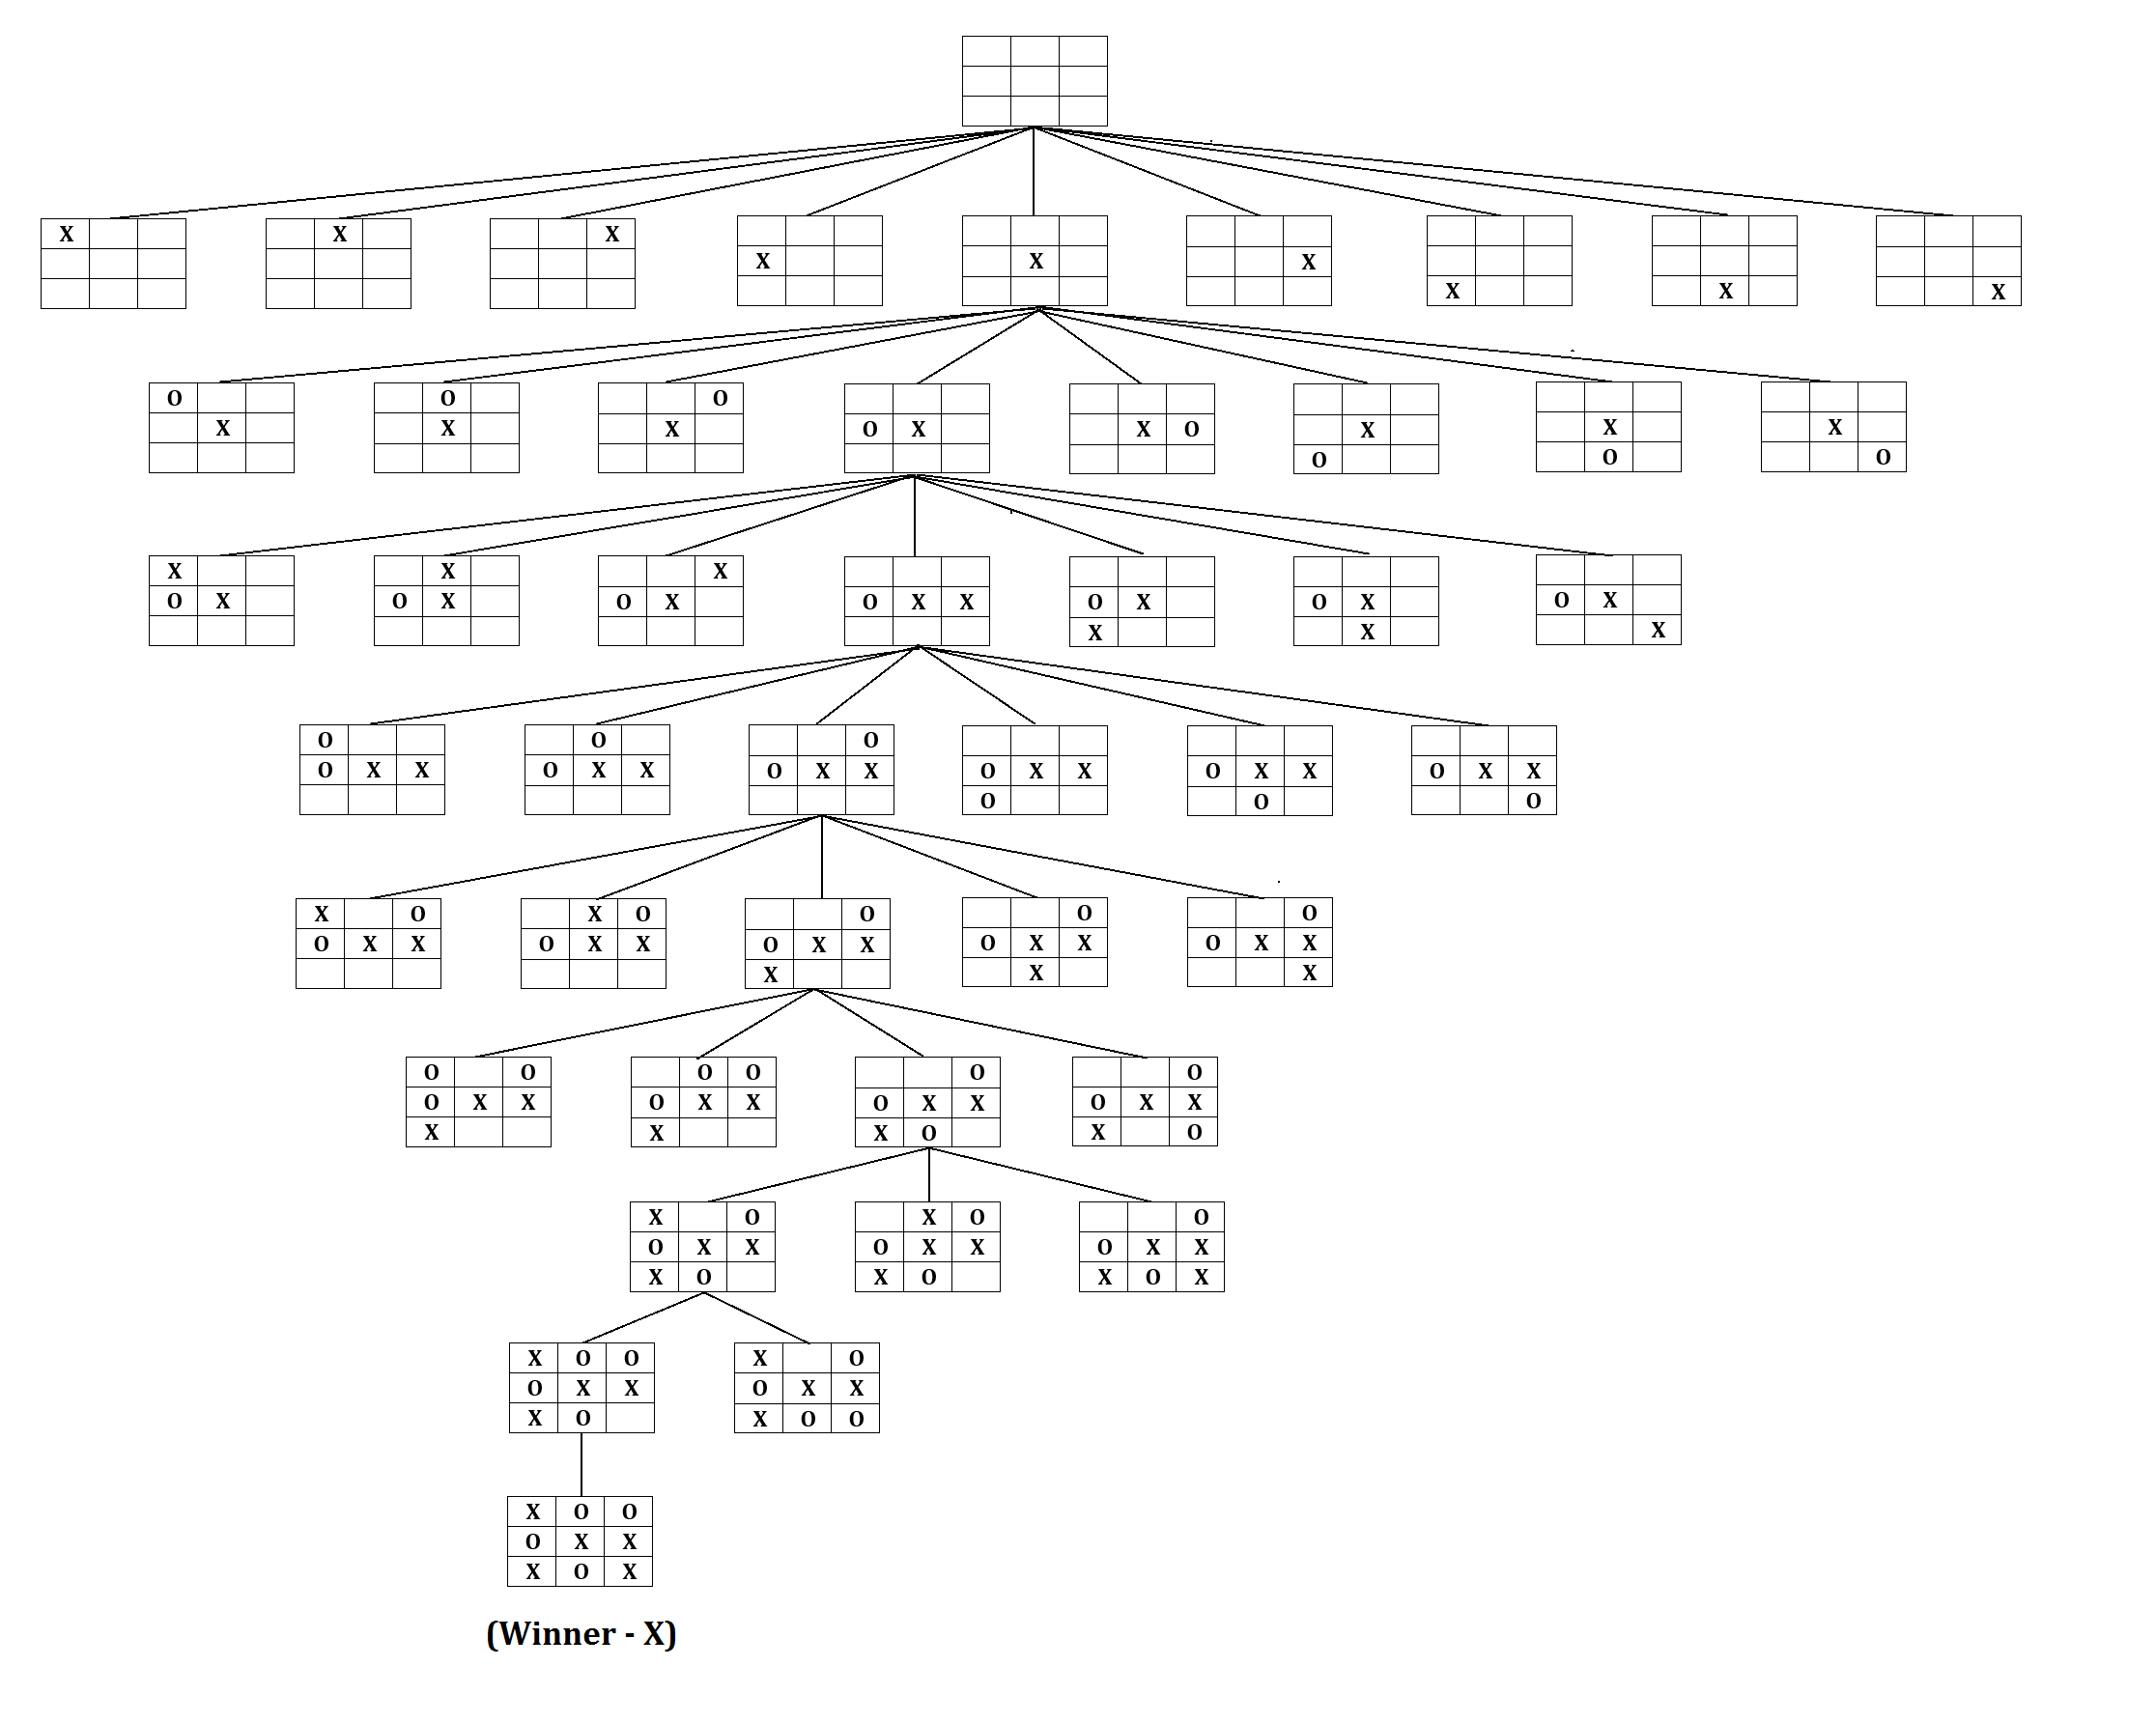

Obviously, DFS will not work out for us :( This is where Monte Carlo Tree Search comes into play. Let's modify the DFS approach to search actions that are more likely to win. This will dramatically reduce time spent searching useless moves, and focus on differentiating between better options. For MCTS, the machine learns to play through the heuristic strategy from simulating many sequences of random gameplay against itself.
# **Building the tree**


There are four phases of implementing MCTS:

1.   Selection
2.   Expansion

1.   Rollout
2.   Backpropagation

Essentially, the algorithm is these four stages repeated under a user defined
time_limit. Since this algorithm does not allocate a lot of resources towards unoptimal actions, it will be able to fully explore good actions under a low time constraint. Below is an illustration demonstrating one of these cycles of MCTS.
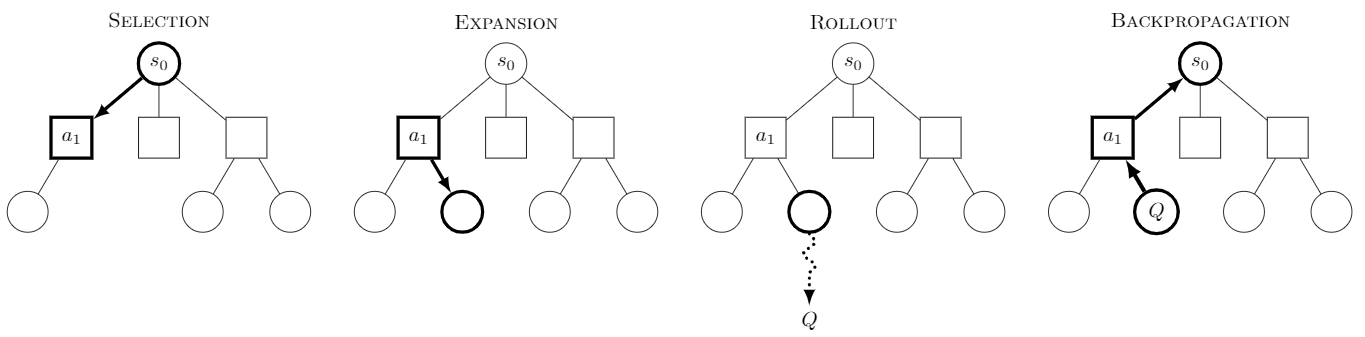

# **Selection Phase**


> This phase is used to select a node in the tree to expand and simulate upon. We select the leaf node with the maximum value that we define. If the leaf node has not been explored upon, we will select that node; otherwise, we will add all possible actions as its children into the tree and randomly select one node.

> To account for the balance of exploration vs exploitation, we will use the Upper Confidence bound (also used by AlphaGo) applied to Trees to determine the value of the node. Below is the equation:



> UCT(n*i*)= Q/N + c*i* (log N*p* / N)^1/2


n*i* is the current node. There are Q amount of wins the agent has out of the N simulations in that given state. c*i* is a float from 0 to 1, representing the exploration rate of the agent. N*p* is the number of simulations that the parent of n*i* has.

As shown in the equation above, it can be observed that the node is more likely to be explored if it yields a high probability of winning, and it has been relatively unexplored in comparison to the parent node.

Below is the node class:

```
class Node:
    def __init__(self, move, parent):
        self.move = move
        self.parent = parent
        self.N = 0
        self.Q = 0
        self.children = {}
        self.outcome = GameMeta.PLAYERS['none']

    def add_children(self, children: dict) -> None:
        for child in children:
            self.children[child.move] = child

    def value(self, explore: float = MCTSMeta.EXPLORATION):
        if self.N == 0:
            #prioritize nodes that are not explored
            return 0 if explore == 0 else GameMeta.INF
        else:
            return self.Q / self.N + explore * math.sqrt(math.log(self.parent.N) / self.N)
```



The code for selecting a node is show below:


```
def select_node(self) -> tuple:
    node = self.root
    state = deepcopy(self.root_state)

    while len(node.children) != 0:
        children = node.children.values()
        max_value = max(children, key=lambda n: n.value()).value()
        # select nodes with the highest UCT value
        max_nodes = [n for n in children if n.value() == max_value]

        # randomly select on to expand upon
        node = random.choice(max_nodes)
        state.move(node.move)

        if node.N == 0:
            return node, state

    if self.expand(node, state): # determines if the state is a terminal state (game over)
        node = random.choice(list(node.children.values()))
        state.move(node.move)

    return node, state

```



# **Expansion Phase**
After the given node is selected, we want to add all possible actions as children of the selected node. Below is the code:


```
def expand(self, parent: Node, state: ConnectState) -> bool:
    if state.game_over():
        return False

    children = [Node(move, parent) for move in state.get_legal_moves()]
    parent.add_children(children)

    return True
```



# **Rollout/Simulation Phase**
In the rollout phase, we are simply simulating through a random game starting from the given state in the input. This function will return the winner of the simulated game to update the probability of each node. Below is the code:


```
def roll_out(self, state: ConnectState) -> int:
    while not state.game_over():
        state.move(random.choice(state.get_legal_moves()))

    return state.get_outcome() # function in the game class shown at the bottom of this blog```



# **Backpropagation Phase**
This step is used to propagate the winner of the simulated game through all of the ancestors of the selected node. We go through all of its ancestors because the selected node's state came from the parents and contributes to the overall "goodness" of the parent states. Below is the code:


```
def back_propagate(self, node: Node, turn: int, outcome: int) -> None:
    # For the current player, not the next player
    reward = 0 if outcome == turn else 1

    while node is not None:
        node.N += 1
        node.Q += reward
        node = node.parent
        if outcome == GameMeta.OUTCOMES['draw']: # we count it as a loss for every state
            reward = 0
        else:
            reward = 1 - reward # alternates between 0 and 1 because each alternate depth represents different player turns
```



Combining the Four Phases
Combining all the phases in order, we will select the node to simulate, then perform rollout on that node and then backpropagate the results onto its parent nodes. We will repeat these steps until time_limit is reached. Below is the code for this step:


```
def search(self, time_limit: int):
    start_time = time.process_time()

    num_rollouts = 0
    while time.process_time() - start_time < time_limit:
        node, state = self.select_node()
        outcome = self.roll_out(state)
        self.back_propagate(node, state.to_play, outcome)
        num_rollouts += 1 # for calculating statistics

    run_time = time.process_time() - start_time
    self.run_time = run_time
    self.num_rollouts = num_rollouts
```
Depending on what kind of computational power your device has, the time_limit will vary. I find that 10...15 seconds (≈20,000 rollouts) is sufficient for it to play at a relatively high level.


# **Choosing Best Action**
With the game tree, choosing the best action is quite trivial. For each node, we choose the action that leads to the state with the most N. It is important to note that we do not choose the highest Q/N because it could come from a relatively unexplored node. However, a node with high N is bound to be a good action because we do not allocate a lot of time to exploring worse-off options. Below is the code to select the best move:


```
def best_move(self):
    if self.root_state.game_over():
        return -1

    max_value = max(self.root.children.values(), key=lambda n: n.N).N
    max_nodes = [n for n in self.root.children.values() if n.N == max_value]
    best_child = random.choice(max_nodes)

    return best_child.move
```

There are a few other functions too. Below is the code to playing Connect 4 with MCTS.




# **MCTS implementation in Connect 4 game:**


---

meta.py - Defines game and MCTS parameters

In [67]:
import math

class GameMeta:
    PLAYERS = {'none': 0, 'one': 1, 'two': 2}
    OUTCOMES = {'none': 0, 'one': 1, 'two': 2, 'draw': 3}
    INF = float('inf')
    ROWS = 6
    COLS = 7


class MCTSMeta:
    EXPLORATION = math.sqrt(2)


ConnectState.py - Game class for Connect 4

In [68]:
from copy import deepcopy
import numpy as np
# from meta import GameMeta


class ConnectState:
    def __init__(self):
        self.board = [[0] * GameMeta.COLS for _ in range(GameMeta.ROWS)]
        self.to_play = GameMeta.PLAYERS['one']
        self.height = [GameMeta.ROWS - 1] * GameMeta.COLS
        self.last_played = []

    def get_board(self):
        return deepcopy(self.board)

    def move(self, col):
        self.board[self.height[col]][col] = self.to_play
        self.last_played = [self.height[col], col]
        self.height[col] -= 1
        self.to_play = GameMeta.PLAYERS['two'] if self.to_play == GameMeta.PLAYERS['one'] else GameMeta.PLAYERS['one']

    def get_legal_moves(self):
        return [col for col in range(GameMeta.COLS) if self.board[0][col] == 0]

    def check_win(self):
        if len(self.last_played) > 0 and self.check_win_from(self.last_played[0], self.last_played[1]):
            return self.board[self.last_played[0]][self.last_played[1]]
        return 0

    def check_win_from(self, row, col):
        player = self.board[row][col]
        """
        Last played action is at (row, col)
        Check surrounding 7x7 grid for a win
        """

        consecutive = 1
        # Check horizontal
        tmprow = row
        while tmprow + 1 < GameMeta.ROWS and self.board[tmprow + 1][col] == player:
            consecutive += 1
            tmprow += 1
        tmprow = row
        while tmprow - 1 >= 0 and self.board[tmprow - 1][col] == player:
            consecutive += 1
            tmprow -= 1

        if consecutive >= 4:
            return True

        # Check vertical
        consecutive = 1
        tmpcol = col
        while tmpcol + 1 < GameMeta.COLS and self.board[row][tmpcol + 1] == player:
            consecutive += 1
            tmpcol += 1
        tmpcol = col
        while tmpcol - 1 >= 0 and self.board[row][tmpcol - 1] == player:
            consecutive += 1
            tmpcol -= 1

        if consecutive >= 4:
            return True

        # Check diagonal
        consecutive = 1
        tmprow = row
        tmpcol = col
        while tmprow + 1 < GameMeta.ROWS and tmpcol + 1 < GameMeta.COLS and self.board[tmprow + 1][tmpcol + 1] == player:
            consecutive += 1
            tmprow += 1
            tmpcol += 1
        tmprow = row
        tmpcol = col
        while tmprow - 1 >= 0 and tmpcol - 1 >= 0 and self.board[tmprow - 1][tmpcol - 1] == player:
            consecutive += 1
            tmprow -= 1
            tmpcol -= 1

        if consecutive >= 4:
            return True

        # Check anti-diagonal
        consecutive = 1
        tmprow = row
        tmpcol = col
        while tmprow + 1 < GameMeta.ROWS and tmpcol - 1 >= 0 and self.board[tmprow + 1][tmpcol - 1] == player:
            consecutive += 1
            tmprow += 1
            tmpcol -= 1
        tmprow = row
        tmpcol = col
        while tmprow - 1 >= 0 and tmpcol + 1 < GameMeta.COLS and self.board[tmprow - 1][tmpcol + 1] == player:
            consecutive += 1
            tmprow -= 1
            tmpcol += 1

        if consecutive >= 4:
            return True

        return False

    def game_over(self):
        return self.check_win() or len(self.get_legal_moves()) == 0

    def get_outcome(self):
        if len(self.get_legal_moves()) == 0 and self.check_win() == 0:
            return GameMeta.OUTCOMES['draw']

        return GameMeta.OUTCOMES['one'] if self.check_win() == GameMeta.PLAYERS['one'] else GameMeta.OUTCOMES['two']

    def print(self):
        print('=============================')

        for row in range(GameMeta.ROWS):
            for col in range(GameMeta.COLS):
                print('| {} '.format('X' if self.board[row][col] == 1 else 'O' if self.board[row][col] == 2 else ' '), end='')
            print('|')

        print('=============================')
        col_labels = "| 0 | 1 | 2 | 3 | 4 | 5 | 6 |"
        print(col_labels)


mcts.py - Monte Carlo Tree Search Agent

In [69]:
import random
import time
import math
from copy import deepcopy

# from ConnectState import ConnectState
# from meta import GameMeta, MCTSMeta


class Node:
    def __init__(self, move, parent):
        self.move = move
        self.parent = parent
        self.N = 0
        self.Q = 0
        self.children = {}
        self.outcome = GameMeta.PLAYERS['none']

    def add_children(self, children: dict) -> None:
        for child in children:
            self.children[child.move] = child

    def value(self, explore: float = MCTSMeta.EXPLORATION):
        if self.N == 0:
            return 0 if explore == 0 else GameMeta.INF
        else:
            return self.Q / self.N + explore * math.sqrt(math.log(self.parent.N) / self.N)


class MCTS:
    def __init__(self, state=ConnectState()):
        self.root_state = deepcopy(state)
        self.root = Node(None, None)
        self.run_time = 0
        self.node_count = 0
        self.num_rollouts = 0

    def select_node(self) -> tuple:
        node = self.root
        state = deepcopy(self.root_state)

        while len(node.children) != 0:
            children = node.children.values()
            max_value = max(children, key=lambda n: n.value()).value()
            max_nodes = [n for n in children if n.value() == max_value]

            node = random.choice(max_nodes)
            state.move(node.move)

            if node.N == 0:
                return node, state

        if self.expand(node, state):
            node = random.choice(list(node.children.values()))
            state.move(node.move)

        return node, state

    def expand(self, parent: Node, state: ConnectState) -> bool:
        if state.game_over():
            return False

        children = [Node(move, parent) for move in state.get_legal_moves()]
        parent.add_children(children)

        return True

    def roll_out(self, state: ConnectState) -> int:
        while not state.game_over():
            state.move(random.choice(state.get_legal_moves()))

        return state.get_outcome()

    def back_propagate(self, node: Node, turn: int, outcome: int) -> None:

        # For the current player, not the next player
        reward = 0 if outcome == turn else 1

        while node is not None:
            node.N += 1
            node.Q += reward
            node = node.parent
            if outcome == GameMeta.OUTCOMES['draw']:
                reward = 0
            else:
                reward = 1 - reward

    def search(self, time_limit: int):
        start_time = time.process_time()

        num_rollouts = 0
        while time.process_time() - start_time < time_limit:
            node, state = self.select_node()
            outcome = self.roll_out(state)
            self.back_propagate(node, state.to_play, outcome)
            num_rollouts += 1

        run_time = time.process_time() - start_time
        self.run_time = run_time
        self.num_rollouts = num_rollouts

    def best_move(self):
        if self.root_state.game_over():
            return -1

        max_value = max(self.root.children.values(), key=lambda n: n.N).N
        max_nodes = [n for n in self.root.children.values() if n.N == max_value]
        best_child = random.choice(max_nodes)

        return best_child.move

    def move(self, move):
        if move in self.root.children:
            self.root_state.move(move)
            self.root = self.root.children[move]
            return

        self.root_state.move(move)
        self.root = Node(None, None)

    def statistics(self) -> tuple:
        return self.num_rollouts, self.run_time


game.py - Main class to play with agent

In [70]:
# from ConnectState import ConnectState
# from montecarloconnect import MCTS


def play():
    state = ConnectState()
    mcts = MCTS(state)

    while not state.game_over():
        print("Current state:")
        state.print()

        user_move = int(input("Enter a move: "))
        while user_move not in state.get_legal_moves():
            print("Illegal move")
            user_move = int(input("Enter a move: "))

        state.move(user_move)
        mcts.move(user_move)

        state.print()

        if state.game_over():
            print("Player one won!")
            break

        print("Thinking...")

        mcts.search(2)
        move = mcts.best_move()

        print("MCTS chose move: ", move)

        state.move(move)
        mcts.move(move)

        # state.print()

        if state.game_over():
            state.move(move)
            mcts.move(move)
            print("Player two won!")
            break


if __name__ == "__main__":
    play()


Current state:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
Enter a move: 5
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   | X |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
Thinking...
MCTS chose move:  0
Current state:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| O |   |   |   |   | X |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
Enter a move: 4
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| O |   |   |   | X | X |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
Thinking...
MCTS chose move:  3
Current state:
|   |   |   |   |  

# **Alpha beta pruning**

---


### **Minimax algorithm**
Minimax algorithm is a recursive algorithm which is used in decision-making and game theory especially in AI game. It provides optimal moves for the player, assuming that the opponent is also playing optimally. For example, considering two opponents: Max and Min playing. Max will try to maximize the value, while Min will choose whatever value is the minimum. The algorithm performs a depth-first search (DFS) which means it will explore the complete game tree as deep as possible, all the way down to the leaf nodes. The algorithm is shown below with an illustrative example.
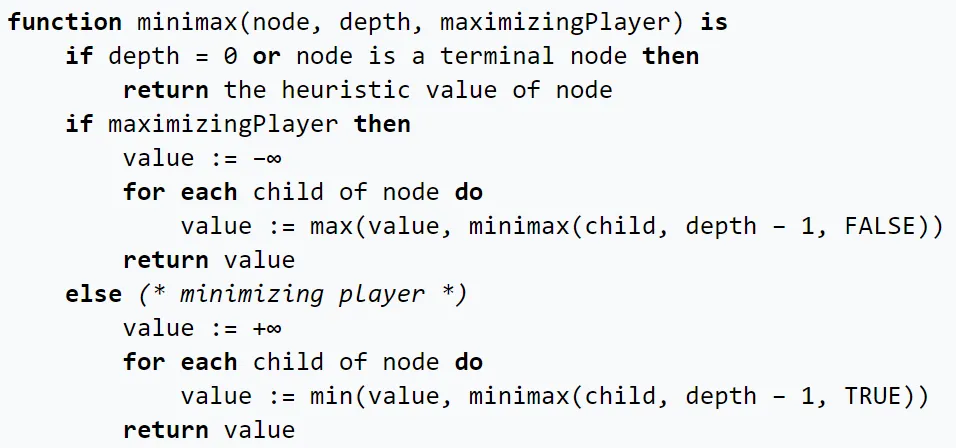

Initially, the algorithm generates the entire game tree and produces the utility values for the terminal states by applying the utility function. For example, in the below tree diagram, let us take A as the tree's initial state. Suppose maximizer takes the first turn, which has a worst-case initial value that equals negative infinity. Then, the minimizer will take the next turn, which has a worst-case initial value that equals positive infinity.
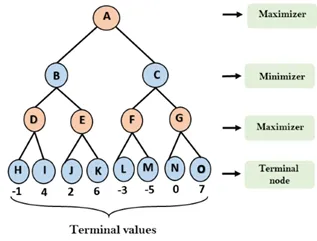

First, we consider the Maximizer with initial value = -∞. Each terminal node will be compared with the value of the maximizer and finally store the maximum value in each maximizer node. Take the third row (Maximizer) from the top, for instance.

For node D max(-1, -∞) → max(-1,4) = 4

For Node E max(2, -∞) → max(2, 6) = 6

For Node F max(-3, -∞) → max(-3,-5) = -3

For node G max(0, -∞) → max(0, 7) = 7

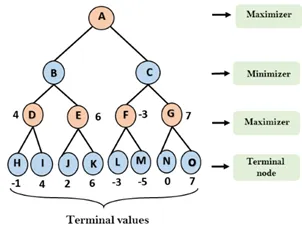

Next, we compare the values from each node with the value of the minimizer, which is +∞.

toFor node B= min(4, 6) = 4

For node C= min(-3, 7) = -3

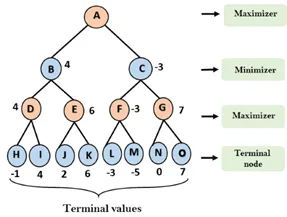

Finally, the maximizer will then again choose the maximum value between node B and node C, which is 4 in this case. Hence, we get the optimal path of play: A → B → D → I.

For node A max(4, -3)= 4

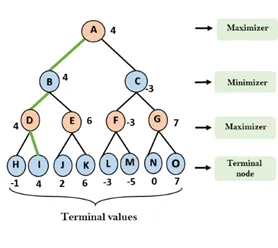

## **AI in Connect Four — Implementing Minimax**
Below is a python snippet of Minimax algorithm implementation in Connect Four. In the code, we extend the original Minimax algorithm by adding the Alpha-beta pruning strategy to improve the computational speed and save memory. The figure below is a pseudocode for the alpha-beta minimax algorithm.

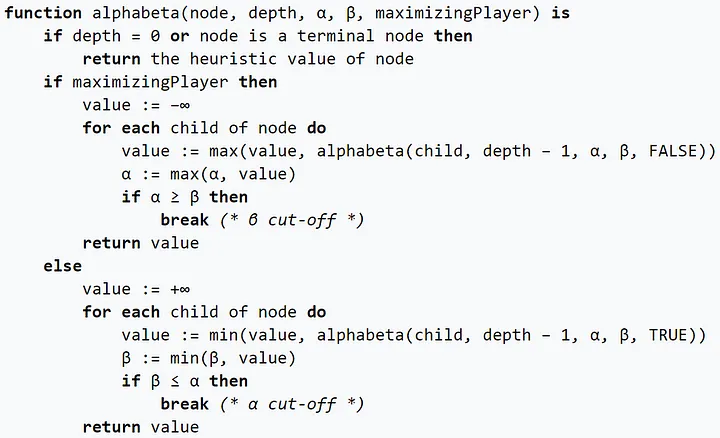

# **Alpha-Beta Pruning Implementation in Connect 4:**

---



In [71]:
import numpy as np
import math

ROW_COUNT = 6
COLUMN_COUNT = 7

PLAYER = 0
AI = 1

EMPTY = 0
PLAYER_PIECE = 1
AI_PIECE = 2

WINDOW_LENGTH = 4


def create_board():
    board = np.zeros((ROW_COUNT, COLUMN_COUNT))
    return board


def drop_piece(board, row, col, piece):
    board[row][col] = piece


def is_valid_location(board, col):
    return board[ROW_COUNT - 1][col] == 0


def get_next_open_row(board, col):
    for r in range(ROW_COUNT):
        if board[r][col] == 0:
            return r
    return None


def print_board(board):
    print("=" * 29)
    for r in range(ROW_COUNT - 1, -1, -1):
        row_str = "|"
        for c in range(COLUMN_COUNT):
            if board[r][c] == PLAYER_PIECE:
                row_str += " X |"
            elif board[r][c] == AI_PIECE:
                row_str += " O |"
            else:
                row_str += "   |"
        print(row_str)

    print("=" * 29)
    col_labels = "| 0 | 1 | 2 | 3 | 4 | 5 | 6 |"
    print(col_labels)


def winning_move(board, piece):
    for c in range(COLUMN_COUNT - 3):
        for r in range(ROW_COUNT):
            if board[r][c] == piece and board[r][c + 1] == piece and board[r][c + 2] == piece and board[r][
                c + 3] == piece:
                return True

    for c in range(COLUMN_COUNT):
        for r in range(ROW_COUNT - 3):
            if board[r][c] == piece and board[r + 1][c] == piece and board[r + 2][c] == piece and board[r + 3][
                c] == piece:
                return True

    for c in range(COLUMN_COUNT - 3):
        for r in range(ROW_COUNT - 3):
            if board[r][c] == piece and board[r + 1][c + 1] == piece and board[r + 2][c + 2] == piece and board[r + 3][
                c + 3] == piece:
                return True

    for c in range(COLUMN_COUNT - 3):
        for r in range(3, ROW_COUNT):
            if board[r][c] == piece and board[r - 1][c + 1] == piece and board[r - 2][c + 2] == piece and board[r - 3][
                c + 3] == piece:
                return True


def evaluate_window(window, piece):
    score = 0
    opp_piece = PLAYER_PIECE
    if piece == PLAYER_PIECE:
        opp_piece = AI_PIECE

    if window.count(piece) == 4:
        score += 100
    elif window.count(piece) == 3 and window.count(EMPTY) == 1:
        score += 5
    elif window.count(piece) == 2 and window.count(EMPTY) == 2:
        score += 2

    if window.count(opp_piece) == 3 and window.count(EMPTY) == 1:
        score -= 4

    return score


def score_position(board, piece):
    score = 0

    center_array = [int(i) for i in list(board[:, COLUMN_COUNT // 2])]
    center_count = center_array.count(piece)
    score += center_count * 3

    for r in range(ROW_COUNT):
        row_array = [int(i) for i in list(board[r, :])]
        for c in range(COLUMN_COUNT - 3):
            window = row_array[c:c + WINDOW_LENGTH]
            score += evaluate_window(window, piece)

    for c in range(COLUMN_COUNT):
        col_array = [int(i) for i in list(board[:, c])]
        for r in range(ROW_COUNT - 3):
            window = col_array[r:r + WINDOW_LENGTH]
            score += evaluate_window(window, piece)

    for r in range(ROW_COUNT - 3):
        for c in range(COLUMN_COUNT - 3):
            window = [board[r + i][c + i] for i in range(WINDOW_LENGTH)]
            score += evaluate_window(window, piece)

    for r in range(ROW_COUNT - 3):
        for c in range(COLUMN_COUNT - 3):
            window = [board[r + 3 - i][c + i] for i in range(WINDOW_LENGTH)]
            score += evaluate_window(window, piece)

    return score


def is_terminal_node(board):
    return winning_move(board, PLAYER_PIECE) or winning_move(board, AI_PIECE) or len(get_valid_locations(board)) == 0


def get_valid_locations(board):
    valid_locations = []
    for col in range(COLUMN_COUNT):
        if is_valid_location(board, col):
            valid_locations.append(col)
    return valid_locations


def minimax(board, depth, alpha, beta, maximizingPlayer):
    valid_locations = get_valid_locations(board)
    is_terminal = is_terminal_node(board)
    if depth == 0 or is_terminal:
        if is_terminal:
            if winning_move(board, AI_PIECE):
                return None, 100000000000000
            elif winning_move(board, PLAYER_PIECE):
                return None, -10000000000000
            else:
                return None, 0
        else:
            return None, score_position(board, AI_PIECE)

    if maximizingPlayer:
        value = -math.inf
        column = valid_locations[0]
        for col in valid_locations:
            row = get_next_open_row(board, col)
            b_copy = board.copy()
            drop_piece(b_copy, row, col, AI_PIECE)
            new_score = minimax(b_copy, depth - 1, alpha, beta, False)[1]
            if new_score > value:
                value = new_score
                column = col
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return column, value
    else:
        value = math.inf
        column = valid_locations[0]
        for col in valid_locations:
            row = get_next_open_row(board, col)
            b_copy = board.copy()
            drop_piece(b_copy, row, col, PLAYER_PIECE)
            new_score = minimax(b_copy, depth - 1, alpha, beta, True)[1]
            if new_score < value:
                value = new_score
                column = col
            beta = min(beta, value)
            if alpha >= beta:
                break
        return column, value


# Rest of your code remains unchanged

# Define a new command-line interface
def get_player_move(board):
    while True:
        try:
            col = int(input("Enter a move: "))
            if is_valid_location(board, col):
                return col
            else:
                print("Invalid move. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number.")


# Modify the game loop
def play_game():
    board = create_board()
    game_over = False
    turn = PLAYER

    while not game_over:
        print_board(board)
        if turn == PLAYER:
            col = get_player_move(board)
        else:
            col, _ = minimax(board, 5, -math.inf, math.inf, True)  # Adjust depth as needed

        row = get_next_open_row(board, col)
        if row is not None:
            drop_piece(board, row, col, turn + 1)

            if winning_move(board, turn + 1):
                print_board(board)
                print(f"Player {turn + 1} wins!!")
                game_over = True

            turn = 1 - turn  # Switch player
        else:
            print("Invalid move. Column is full. Please try again.")


play_game()


|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
Enter a move: 4
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   | X |   |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | O | X |   |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
Enter a move: 5
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | O | X | X |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   

# **Agent vs agent Connect 4 Implementation**

---



### Simple agent vs random agent

In [3]:
import numpy as np
import random

# Function to create an empty Connect 4 board
def create_board():
    return np.zeros((6, 7), dtype=int)

# Function to print the Connect 4 board
def print_board(board):
    print('=============================')
    for row in range(6):
        for col in range(7):
            print('| {} '.format('X' if board[row][col] == 1 else 'O' if board[row][col] == 2 else ' '), end='')
        print('|')
    print('=============================')
    col_labels = "| 0 | 1 | 2 | 3 | 4 | 5 | 6 |"
    print(col_labels)

# Function to drop a piece into a column
def drop_piece(board, row, col, piece):
    board[row][col] = piece

# Function to check if a move is valid
def is_valid_location(board, col):
    return board[0][col] == 0

# Function to get the next open row in a column
def get_next_open_row(board, col):
    for r in range(5, -1, -1):
        if board[r][col] == 0:
            return r

# Function to check for a winning move
def winning_move(board, piece):
    # Check horizontal locations
    for c in range(4):
        for r in range(6):
            if board[r][c] == piece and board[r][c+1] == piece and board[r][c+2] == piece and board[r][c+3] == piece:
                return True

    # Check vertical locations
    for c in range(7):
        for r in range(3):
            if board[r][c] == piece and board[r+1][c] == piece and board[r+2][c] == piece and board[r+3][c] == piece:
                return True

    # Check positively sloped diagonals
    for c in range(4):
        for r in range(3):
            if board[r][c] == piece and board[r+1][c+1] == piece and board[r+2][c+2] == piece and board[r+3][c+3] == piece:
                return True

    # Check negatively sloped diagonals
    for c in range(4):
        for r in range(3, 6):
            if board[r][c] == piece and board[r-1][c+1] == piece and board[r-2][c+2] == piece and board[r-3][c+3] == piece:
                return True

    return False

# AI Player using random moves
class RandomAI:
    def __init__(self):
        pass

    def get_move(self, board):
        valid_moves = [c for c in range(7) if is_valid_location(board, c)]
        return random.choice(valid_moves)

# AI Player using a simple evaluation function
class SimpleAI:
    def __init__(self, piece):
        self.piece = piece
        self.opponent_piece = 1 if piece == 2 else 2

    def get_move(self, board):
        valid_moves = [c for c in range(7) if is_valid_location(board, c)]
        best_score = -10000
        best_move = random.choice(valid_moves)

        for col in valid_moves:
            row = get_next_open_row(board, col)
            temp_board = board.copy()
            drop_piece(temp_board, row, col, self.piece)
            score = self.evaluate(temp_board)

            if score > best_score:
                best_score = score
                best_move = col

        return best_move

    def evaluate(self, board):
        score = 0
        center_array = [int(i) for i in list(board[:, 3])]
        center_count = center_array.count(self.piece)
        score += center_count * 3

        for r in range(6):
            row_array = [int(i) for i in list(board[r, :])]
            for c in range(4):
                window = row_array[c:c+4]
                score += self.evaluate_window(window)

        for c in range(7):
            col_array = [int(i) for i in list(board[:, c])]
            for r in range(3):
                window = col_array[r:r+4]
                score += self.evaluate_window(window)

        for r in range(3):
            for c in range(4):
                window = [board[r+i][c+i] for i in range(4)]
                score += self.evaluate_window(window)

        for r in range(3):
            for c in range(3, 7):
                window = [board[r+i][c-i] for i in range(4)]
                score += self.evaluate_window(window)

        return score

    def evaluate_window(self, window):
        score = 0
        if window.count(self.piece) == 4:
            score += 100
        elif window.count(self.piece) == 3 and window.count(0) == 1:
            score += 5
        elif window.count(self.piece) == 2 and window.count(0) == 2:
            score += 2
        if window.count(self.opponent_piece) == 3 and window.count(0) == 1:
            score -= 4
        return score

# Main game class
class Connect4Game:
    def __init__(self):
        self.board = create_board()
        self.current_player = 1  # Player 1 starts
        self.ai_players = [SimpleAI(1), SimpleAI(2)]  # Replace RandomAI with SimpleAI for both players

    def play(self):
        while True:
            print_board(self.board)

            col = self.ai_players[self.current_player - 1].get_move(self.board)

            if is_valid_location(self.board, col):
                row = get_next_open_row(self.board, col)
                drop_piece(self.board, row, col, self.current_player)

                if winning_move(self.board, self.current_player):
                    print_board(self.board)
                    print(f"Player {self.current_player} wins!")
                    break

                self.current_player = 1 if self.current_player == 2 else 2

if __name__ == "__main__":
    game = Connect4Game()
    game.play()


|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | O |   |   |   |
|   |   |   | X |   |   |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | O |   |   |   |
|   |   | X | X |   |   |   |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   | O | O |   |   |   |
|   |   | 

## Alpha beta pruning agent vs Monte Carlo agent

In [20]:
import numpy as np
import math
import random
import time

ROW_COUNT = 6
COLUMN_COUNT = 7

PLAYER = 0
AI = 1

EMPTY = 0
PLAYER_PIECE = "X"
AI_PIECE = "O"

WINDOW_LENGTH = 4

class Connect4Game:
    def __init__(self):
        self.board = np.full((ROW_COUNT, COLUMN_COUNT), EMPTY, dtype=str)
        self.current_player = random.choice([PLAYER, AI])
        self.time_limit = 0

    def drop_piece(self, col):
        row = self.get_next_open_row(col)
        self.board[row][col] = PLAYER_PIECE if self.current_player == PLAYER else AI_PIECE

    def is_valid_location(self, col):
        return self.board[ROW_COUNT - 1][col] == EMPTY

    def get_next_open_row(self, col):
        for r in range(ROW_COUNT):
            if self.board[r][col] == EMPTY:
                return r
        return None

    def print_board(self):
        print("=" * 29)
        for r in range(ROW_COUNT - 1, -1, -1):
            row_str = "|"
            for c in range(COLUMN_COUNT):
                row_str += f" {self.board[r][c]} |"
            print(row_str)

        print("=" * 29)
        col_labels = "| 0 | 1 | 2 | 3 | 4 | 5 | 6 |"
        print(col_labels)

    def winning_move(self):
        for c in range(COLUMN_COUNT - 3):
            for r in range(ROW_COUNT):
                if self.board[r][c] == PLAYER_PIECE and self.board[r][c + 1] == PLAYER_PIECE and self.board[r][c + 2] == PLAYER_PIECE and self.board[r][c + 3] == PLAYER_PIECE:
                    return True

        for c in range(COLUMN_COUNT):
            for r in range(ROW_COUNT - 3):
                if self.board[r][c] == PLAYER_PIECE and self.board[r + 1][c] == PLAYER_PIECE and self.board[r + 2][c] == PLAYER_PIECE and self.board[r + 3][c] == PLAYER_PIECE:
                    return True

        for c in range(COLUMN_COUNT - 3):
            for r in range(ROW_COUNT - 3):
                if self.board[r][c] == PLAYER_PIECE and self.board[r + 1][c + 1] == PLAYER_PIECE and self.board[r + 2][c + 2] == PLAYER_PIECE and self.board[r + 3][c + 3] == PLAYER_PIECE:
                    return True

        for c in range(COLUMN_COUNT - 3):
            for r in range(3, ROW_COUNT):
                if self.board[r][c] == PLAYER_PIECE and self.board[r - 1][c + 1] == PLAYER_PIECE and self.board[r - 2][c + 2] == PLAYER_PIECE and self.board[r - 3][c + 3] == PLAYER_PIECE:
                    return True

        return False

    def is_terminal_node(self):
        return self.winning_move() or len(self.get_valid_locations()) == 0

    def get_valid_locations(self):
        valid_locations = []
        for col in range(COLUMN_COUNT):
            if self.is_valid_location(col):
                valid_locations.append(col)
        return valid_locations

    def play_move_alpha_beta(self, depth):
        best_move, _ = self.minimax(self, depth, True)
        self.drop_piece(best_move)

    def minimax(self, game, depth, is_maximizing):
        if depth == 0 or game.is_terminal_node():
            if game.winning_move():
                return None, 100000000000000 if game.current_player == AI else -10000000000000
            else:
                return None, 0

        if is_maximizing:
            value = -math.inf
            column = game.get_valid_locations()[0]
            for col in game.get_valid_locations():
                row = game.get_next_open_row(col)
                board_copy = np.copy(game.board)
                game.drop_piece(col)
                new_score = self.minimax(game, depth - 1, False)[1]
                if new_score > value:
                    value = new_score
                    column = col
                game.board = np.copy(board_copy)
            return column, value
        else:
            value = math.inf
            column = game.get_valid_locations()[0]
            for col in game.get_valid_locations():
                row = game.get_next_open_row(col)
                board_copy = np.copy(game.board)
                game.drop_piece(col)
                new_score = self.minimax(game, depth - 1, True)[1]
                if new_score < value:
                    value = new_score
                    column = col
                game.board = np.copy(board_copy)
            return column, value

    def play_move_monte_carlo(self, time_limit):
        start_time = time.time()
        while time.time() - start_time < time_limit:
            self.monte_carlo_tree_search()

    def monte_carlo_tree_search(self):
        root = Node(game=self)

        while time.time() - start_time < self.time_limit:
            leaf = self.traverse(root)
            outcome = self.rollout(leaf)
            self.backpropagate(leaf, outcome)

        best_child = root.get_best_child()
        self.board = np.copy(best_child.game.board)

    def traverse(self, node):
        while not node.is_terminal() and node.is_fully_expanded():
            node = node.get_best_child()
        if not node.is_terminal():
            node = node.expand()
        return node

    def rollout(self, node):
        game = node.game.copy()
        while not game.winning_move() and len(game.get_valid_locations()) > 0:
            random_col = random.choice(game.get_valid_locations())
            game.drop_piece(random_col)

        if game.winning_move():
            return 1 if game.current_player == AI else -1
        return 0

    def backpropagate(self, node, outcome):
        while node is not None:
            node.N += 1
            node.Q += outcome
            node = node.parent

class Node:
    def __init__(self, game, parent=None, move=None):
        self.game = game
        self.parent = parent
        self.move = move
        self.children = []
        self.N = 0
        self.Q = 0

    def is_terminal(self):
        return self.game.is_terminal_node()

    def is_fully_expanded(self):
        return len(self.children) == len(self.game.get_valid_locations())

    def expand(self):
        untried_moves = [move for move in self.game.get_valid_locations() if move not in [child.move for child in self.children]]
        if untried_moves:
            move = random.choice(untried_moves)
            child_game = self.game.copy()
            child_game.drop_piece(move)
            child = Node(game=child_game, parent=self, move=move)
            self.children.append(child)
            return child
        return self

    def get_best_child(self):
        if self.children:
            best_child = max(self.children, key=lambda x: x.Q / (x.N + 1e-5) + math.sqrt(2 * math.log(self.N) / (x.N + 1e-5)))
            return best_child

if __name__ == "__main__":
    game = Connect4Game()

    while not game.winning_move() and len(game.get_valid_locations()) > 0:
        if game.current_player == PLAYER:
            game.play_move_alpha_beta(5)  # Adjust depth as needed
        else:
            game.play_move_monte_carlo(8)  # Adjust time_limit as needed

        game.print_board()

    if game.winning_move():
        winner = "Player 1 (Alpha-Beta)" if game.current_player == PLAYER else "Player 2 (Monte Carlo)"
        print(f"{winner} wins!")
    else:
        print("It's a draw!")

It's a draw!


In [15]:
import math
import random
import time
from copy import deepcopy

class GameMeta:
    PLAYERS = {'none': 0, 'one': 1, 'two': 2}
    OUTCOMES = {'none': 0, 'one': 1, 'two': 2, 'draw': 3}
    INF = float('inf')
    ROWS = 6
    COLS = 7

class MCTSMeta:
    EXPLORATION = math.sqrt(2)

class ConnectState:
    def __init__(self):
        self.board = [[0] * GameMeta.COLS for _ in range(GameMeta.ROWS)]
        self.to_play = GameMeta.PLAYERS['one']
        self.height = [GameMeta.ROWS - 1] * GameMeta.COLS
        self.last_played = []

    def get_board(self):
        return deepcopy(self.board)

    def move(self, col):
        self.board[self.height[col]][col] = self.to_play
        self.last_played = [self.height[col], col]
        self.height[col] -= 1
        self.to_play = GameMeta.PLAYERS['two'] if self.to_play == GameMeta.PLAYERS['one'] else GameMeta.PLAYERS['one']

    def get_legal_moves(self):
        return [col for col in range(GameMeta.COLS) if self.board[0][col] == 0]

    def check_win(self):
        if len(self.last_played) > 0 and self.check_win_from(self.last_played[0], self.last_played[1]):
            return self.board[self.last_played[0]][self.last_played[1]]
        return 0

    def check_win_from(self, row, col):
        player = self.board[row][col]
        consecutive = 1

        # Check horizontal
        tmprow = row
        while tmprow + 1 < GameMeta.ROWS and self.board[tmprow + 1][col] == player:
            consecutive += 1
            tmprow += 1
        tmprow = row
        while tmprow - 1 >= 0 and self.board[tmprow - 1][col] == player:
            consecutive += 1
            tmprow -= 1

        if consecutive >= 4:
            return True

        # Check vertical
        consecutive = 1
        tmpcol = col
        while tmpcol + 1 < GameMeta.COLS and self.board[row][tmpcol + 1] == player:
            consecutive += 1
            tmpcol += 1
        tmpcol = col
        while tmpcol - 1 >= 0 and self.board[row][tmpcol - 1] == player:
            consecutive += 1
            tmpcol -= 1

        if consecutive >= 4:
            return True

        # Check diagonal
        consecutive = 1
        tmprow = row
        tmpcol = col
        while tmprow + 1 < GameMeta.ROWS and tmpcol + 1 < GameMeta.COLS and self.board[tmprow + 1][tmpcol + 1] == player:
            consecutive += 1
            tmprow += 1
            tmpcol += 1
        tmprow = row
        tmpcol = col
        while tmprow - 1 >= 0 and tmpcol - 1 >= 0 and self.board[tmprow - 1][tmpcol - 1] == player:
            consecutive += 1
            tmprow -= 1
            tmpcol -= 1

        if consecutive >= 4:
            return True

        # Check anti-diagonal
        consecutive = 1
        tmprow = row
        tmpcol = col
        while tmprow + 1 < GameMeta.ROWS and tmpcol - 1 >= 0 and self.board[tmprow + 1][tmpcol - 1] == player:
            consecutive += 1
            tmprow += 1
            tmpcol -= 1
        tmprow = row
        tmpcol = col
        while tmprow - 1 >= 0 and tmpcol + 1 < GameMeta.COLS and self.board[tmprow - 1][tmpcol + 1] == player:
            consecutive += 1
            tmprow -= 1
            tmpcol += 1

        if consecutive >= 4:
            return True

        return False

    def game_over(self):
        return self.check_win() or len(self.get_legal_moves()) == 0

    def get_outcome(self):
        if len(self.get_legal_moves()) == 0 and self.check_win() == 0:
            return GameMeta.OUTCOMES['draw']

        return GameMeta.OUTCOMES['one'] if self.check_win() == GameMeta.PLAYERS['one'] else GameMeta.OUTCOMES['two']

    def print(self):
        print('=============================')
        for row in range(GameMeta.ROWS):
            for col in range(GameMeta.COLS):
                print('| {} '.format('X' if self.board[row][col] == 1 else 'O' if self.board[row][col] == 2 else ' '), end='')
            print('|')
        print('=============================')

class Node:
    def __init__(self, move, parent):
        self.move = move
        self.parent = parent
        self.N = 0
        self.Q = 0
        self.children = {}
        self.outcome = GameMeta.PLAYERS['none']

    def add_children(self, children):
        for child in children:
            self.children[child.move] = child

    def value(self, explore=MCTSMeta.EXPLORATION):
        if self.N == 0:
            return 0 if explore == 0 else GameMeta.INF
        else:
            return self.Q / self.N + explore * math.sqrt(math.log(self.parent.N) / self.N)

class MCTS:
    def __init__(self, state=ConnectState()):
        self.root_state = deepcopy(state)
        self.root = Node(None, None)
        self.run_time = 0
        self.node_count = 0
        self.num_rollouts = 0

    def select_node(self):
        node = self.root
        state = deepcopy(self.root_state)

        while len(node.children) != 0:
            children = node.children.values()
            max_value = max(children, key=lambda n: n.value()).value()
            max_nodes = [n for n in children if n.value() == max_value]

            node = random.choice(max_nodes)
            state.move(node.move)

            if node.N == 0:
                return node, state

        if self.expand(node, state):
            node = random.choice(list(node.children.values()))
            state.move(node.move)

        return node, state

    def expand(self, parent, state):
        if state.game_over():
            return False

        children = [Node(move, parent) for move in state.get_legal_moves()]
        parent.add_children(children)

        return True

    def roll_out(self, state):
        while not state.game_over():
            state.move(random.choice(state.get_legal_moves()))

        return state.get_outcome()

    def back_propagate(self, node, turn, outcome):
        reward = 0 if outcome == turn else 1

        while node is not None:
            node.N += 1
            node.Q += reward
            node = node.parent
            if outcome == GameMeta.OUTCOMES['draw']:
                reward = 0
            else:
                reward = 1 - reward

    def search(self, time_limit):
        start_time = time.process_time()

        num_rollouts = 0
        while time.process_time() - start_time < time_limit:
            node, state = self.select_node()
            outcome = self.roll_out(state)
            self.back_propagate(node, state.to_play, outcome)
            num_rollouts += 1

        run_time = time.process_time() - start_time
        self.run_time = run_time
        self.num_rollouts = num_rollouts

    def best_move(self):
        if self.root_state.game_over():
            return -1

        max_value = max(self.root.children.values(), key=lambda n: n.N).N
        max_nodes = [n for n in self.root.children.values() if n.N == max_value]
        best_child = random.choice(max_nodes)

        return best_child.move

    def move(self, move):
        if move in self.root.children:
            self.root_state.move(move)
            self.root = self.root.children[move]
            return

        self.root_state.move(move)
        self.root = Node(None, None)

    def statistics(self):
        return self.num_rollouts, self.run_time

class AlphaBetaPruningAgent:
    def get_best_move(self, state):
        return self.alpha_beta_search(state, 6, -GameMeta.INF, GameMeta.INF)

    def alpha_beta_search(self, state, depth, alpha, beta):
        if depth == 0 or state.game_over():
            return self.evaluate_state(state)

        if state.to_play == GameMeta.PLAYERS['one']:
            max_eval = -GameMeta.INF
            for move in state.get_legal_moves():
                child_state = deepcopy(state)
                child_state.move(move)
                eval = self.alpha_beta_search(child_state, depth - 1, alpha, beta)
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = GameMeta.INF
            for move in state.get_legal_moves():
                child_state = deepcopy(state)
                child_state.move(move)
                eval = self.alpha_beta_search(child_state, depth - 1, alpha, beta)
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

    def evaluate_state(self, state):
        # A simple evaluation function:
        # 1. Count the number of player's pieces in potential winning positions (3 in a row)
        # 2. Subtract the number of opponent's pieces in similar positions
        # 3. Return the difference as the evaluation score

        player = state.to_play
        opponent = (
            GameMeta.PLAYERS['one']
            if player == GameMeta.PLAYERS['two']
            else GameMeta.PLAYERS['two']
        )

        player_score = 0
        opponent_score = 0

        # Check for potential winning positions
        for row in range(GameMeta.ROWS):
            for col in range(GameMeta.COLS):
                if state.board[row][col] == player:
                    # Check horizontally
                    if col + 3 < GameMeta.COLS:
                        if (
                            state.board[row][col + 1] == player
                            and state.board[row][col + 2] == player
                            and state.board[row][col + 3] == 0
                        ):
                            player_score += 1
                    # Similar checks can be made for vertical, diagonal, and anti-diagonal

        for row in range(GameMeta.ROWS):
            for col in range(GameMeta.COLS):
                if state.board[row][col] == opponent:
                    # Check horizontally
                    if col + 3 < GameMeta.COLS:
                        if (
                            state.board[row][col + 1] == opponent
                            and state.board[row][col + 2] == opponent
                            and state.board[row][col + 3] == 0
                        ):
                            opponent_score += 1
                    # Similar checks can be made for vertical, diagonal, and anti-diagonal

        return player_score - opponent_score

# Now, you can create instances of these classes to set up a game between the agents.

# Example of how to create a game and play it:
if __name__ == "__main__":
    game = ConnectState()
    mcts_agent = MCTS(game)
    alpha_beta_agent = AlphaBetaPruningAgent()

    while not game.game_over():
        if game.to_play == GameMeta.PLAYERS['one']:
            # MCTS agent's turn
            mcts_agent.search(1)  # Perform MCTS for 1 second
            mcts_move = mcts_agent.best_move()
            game.move(mcts_move)
            print("MCTS Agent's Move:")
            game.print()
        else:
            # Alpha-Beta Pruning agent's turn
            alpha_beta_move = alpha_beta_agent.get_best_move(game)
            game.move(alpha_beta_move)
            print("Alpha-Beta Agent's Move:")
            game.print()

    outcome = game.get_outcome()
    if outcome == GameMeta.OUTCOMES['draw']:
        print("It's a draw!")
    else:
        winner = "MCTS Agent" if outcome == GameMeta.PLAYERS['one'] else "Alpha-Beta Agent"
        print(f"{winner} wins!")

# This code sets up a Connect Four game and lets the two agents take turns until the game is over.


MCTS Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | X |
Alpha-Beta Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| O |   |   |   |   |   | X |
MCTS Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | X |
| O |   |   |   |   |   | X |
Alpha-Beta Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| O |   |   |   |   |   | X |
| O |   |   |   |   |   | X |
MCTS Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | X |
| O |   |   |   |   |   | X |
| O |   |   |   |   |  

In [14]:
import math
import random
import time
from copy import deepcopy

class GameMeta:
    PLAYERS = {'none': 0, 'one': 1, 'two': 2}
    OUTCOMES = {'none': 0, 'one': 1, 'two': 2, 'draw': 3}
    INF = float('inf')
    ROWS = 6
    COLS = 7

class MCTSMeta:
    EXPLORATION = math.sqrt(2)

class ConnectState:
    def __init__(self):
        self.board = [[0] * GameMeta.COLS for _ in range(GameMeta.ROWS)]
        self.to_play = GameMeta.PLAYERS['one']
        self.height = [GameMeta.ROWS - 1] * GameMeta.COLS
        self.last_played = []

    def get_board(self):
        return deepcopy(self.board)

    def move(self, col):
        self.board[self.height[col]][col] = self.to_play
        self.last_played = [self.height[col], col]
        self.height[col] -= 1
        self.to_play = GameMeta.PLAYERS['two'] if self.to_play == GameMeta.PLAYERS['one'] else GameMeta.PLAYERS['one']

    def get_legal_moves(self):
        return [col for col in range(GameMeta.COLS) if self.board[0][col] == 0]

    def check_win(self):
        if len(self.last_played) > 0 and self.check_win_from(self.last_played[0], self.last_played[1]):
            return self.board[self.last_played[0]][self.last_played[1]]
        return 0

    def check_win_from(self, row, col):
        player = self.board[row][col]
        consecutive = 1

        # Check horizontal
        tmprow = row
        while tmprow + 1 < GameMeta.ROWS and self.board[tmprow + 1][col] == player:
            consecutive += 1
            tmprow += 1
        tmprow = row
        while tmprow - 1 >= 0 and self.board[tmprow - 1][col] == player:
            consecutive += 1
            tmprow -= 1

        if consecutive >= 4:
            return True

        # Check vertical
        consecutive = 1
        tmpcol = col
        while tmpcol + 1 < GameMeta.COLS and self.board[row][tmpcol + 1] == player:
            consecutive += 1
            tmpcol += 1
        tmpcol = col
        while tmpcol - 1 >= 0 and self.board[row][tmpcol - 1] == player:
            consecutive += 1
            tmpcol -= 1

        if consecutive >= 4:
            return True

        # Check diagonal
        consecutive = 1
        tmprow = row
        tmpcol = col
        while tmprow + 1 < GameMeta.ROWS and tmpcol + 1 < GameMeta.COLS and self.board[tmprow + 1][tmpcol + 1] == player:
            consecutive += 1
            tmprow += 1
            tmpcol += 1
        tmprow = row
        tmpcol = col
        while tmprow - 1 >= 0 and tmpcol - 1 >= 0 and self.board[tmprow - 1][tmpcol - 1] == player:
            consecutive += 1
            tmprow -= 1
            tmpcol -= 1

        if consecutive >= 4:
            return True

        # Check anti-diagonal
        consecutive = 1
        tmprow = row
        tmpcol = col
        while tmprow + 1 < GameMeta.ROWS and tmpcol - 1 >= 0 and self.board[tmprow + 1][tmpcol - 1] == player:
            consecutive += 1
            tmprow += 1
            tmpcol -= 1
        tmprow = row
        tmpcol = col
        while tmprow - 1 >= 0 and tmpcol + 1 < GameMeta.COLS and self.board[tmprow - 1][tmpcol + 1] == player:
            consecutive += 1
            tmprow -= 1
            tmpcol += 1

        if consecutive >= 4:
            return True

        return False

    def game_over(self):
        return self.check_win() or len(self.get_legal_moves()) == 0

    def get_outcome(self):
        if len(self.get_legal_moves()) == 0 and self.check_win() == 0:
            return GameMeta.OUTCOMES['draw']

        return GameMeta.OUTCOMES['one'] if self.check_win() == GameMeta.PLAYERS['one'] else GameMeta.OUTCOMES['two']

    def print(self):
        print('=============================')
        for row in range(GameMeta.ROWS):
            for col in range(GameMeta.COLS):
                print('| {} '.format('X' if self.board[row][col] == 1 else 'O' if self.board[row][col] == 2 else ' '), end='')
            print('|')
        print('=============================')

class Node:
    def __init__(self, move, parent):
        self.move = move
        self.parent = parent
        self.N = 0
        self.Q = 0
        self.children = {}
        self.outcome = GameMeta.PLAYERS['none']

    def add_children(self, children):
        for child in children:
            self.children[child.move] = child

    def value(self, explore=MCTSMeta.EXPLORATION):
        if self.N == 0:
            return 0 if explore == 0 else GameMeta.INF
        else:
            return self.Q / self.N + explore * math.sqrt(math.log(self.parent.N) / self.N)

class MCTS:
    def __init__(self, state=ConnectState()):
        self.root_state = deepcopy(state)
        self.root = Node(None, None)
        self.run_time = 0
        self.node_count = 0
        self.num_rollouts = 0

    def select_node(self):
        node = self.root
        state = deepcopy(self.root_state)

        while len(node.children) != 0:
            children = node.children.values()
            max_value = max(children, key=lambda n: n.value()).value()
            max_nodes = [n for n in children if n.value() == max_value]

            node = random.choice(max_nodes)
            state.move(node.move)

            if node.N == 0:
                return node, state

        if self.expand(node, state):
            node = random.choice(list(node.children.values()))
            state.move(node.move)

        return node, state

    def expand(self, parent, state):
        if state.game_over():
            return False

        children = [Node(move, parent) for move in state.get_legal_moves()]
        parent.add_children(children)

        return True

    def roll_out(self, state):
        while not state.game_over():
            state.move(random.choice(state.get_legal_moves()))

        return state.get_outcome()

    def back_propagate(self, node, turn, outcome):
        reward = 0 if outcome == turn else 1

        while node is not None:
            node.N += 1
            node.Q += reward
            node = node.parent
            if outcome == GameMeta.OUTCOMES['draw']:
                reward = 0
            else:
                reward = 1 - reward

    def search(self, time_limit):
        start_time = time.process_time()

        num_rollouts = 0
        while time.process_time() - start_time < time_limit:
            node, state = self.select_node()
            outcome = self.roll_out(state)
            self.back_propagate(node, state.to_play, outcome)
            num_rollouts += 1

        run_time = time.process_time() - start_time
        self.run_time = run_time
        self.num_rollouts = num_rollouts

    def best_move(self):
        if self.root_state.game_over():
            return -1

        max_value = max(self.root.children.values(), key=lambda n: n.N).N
        max_nodes = [n for n in self.root.children.values() if n.N == max_value]
        best_child = random.choice(max_nodes)

        return best_child.move

    def move(self, move):
        if move in self.root.children:
            self.root_state.move(move)
            self.root = self.root.children[move]
            return

        self.root_state.move(move)
        self.root = Node(None, None)

    def statistics(self):
        return self.num_rollouts, self.run_time

class AlphaBetaPruningAgent:
    def get_best_move(self, state):
        return self.alpha_beta_search(state, 8, -GameMeta.INF, GameMeta.INF)

    def alpha_beta_search(self, state, depth, alpha, beta):
        if depth == 0 or state.game_over():
            return self.evaluate_state(state)

        if state.to_play == GameMeta.PLAYERS['one']:
            max_eval = -GameMeta.INF
            for move in state.get_legal_moves():
                child_state = deepcopy(state)
                child_state.move(move)
                eval = self.alpha_beta_search(child_state, depth - 1, alpha, beta)
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = GameMeta.INF
            for move in state.get_legal_moves():
                child_state = deepcopy(state)
                child_state.move(move)
                eval = self.alpha_beta_search(child_state, depth - 1, alpha, beta)
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

    def evaluate_state(self, state):
        # A simple evaluation function:
        # 1. Count the number of player's pieces in potential winning positions (3 in a row)
        # 2. Subtract the number of opponent's pieces in similar positions
        # 3. Return the difference as the evaluation score

        player = state.to_play
        opponent = (
            GameMeta.PLAYERS['one']
            if player == GameMeta.PLAYERS['two']
            else GameMeta.PLAYERS['two']
        )

        player_score = 0
        opponent_score = 0

        # Check for potential winning positions
        for row in range(GameMeta.ROWS):
            for col in range(GameMeta.COLS):
                if state.board[row][col] == player:
                    # Check horizontally
                    if col + 3 < GameMeta.COLS:
                        if (
                            state.board[row][col + 1] == player
                            and state.board[row][col + 2] == player
                            and state.board[row][col + 3] == 0
                        ):
                            player_score += 1
                    # Similar checks can be made for vertical, diagonal, and anti-diagonal

        for row in range(GameMeta.ROWS):
            for col in range(GameMeta.COLS):
                if state.board[row][col] == opponent:
                    # Check horizontally
                    if col + 3 < GameMeta.COLS:
                        if (
                            state.board[row][col + 1] == opponent
                            and state.board[row][col + 2] == opponent
                            and state.board[row][col + 3] == 0
                        ):
                            opponent_score += 1
                    # Similar checks can be made for vertical, diagonal, and anti-diagonal

        return player_score - opponent_score

# Now, you can create instances of these classes to set up a game between the agents.

# Example of how to create a game and play it:
if __name__ == "__main__":
    game = ConnectState()
    mcts_agent = MCTS(game)
    alpha_beta_agent = AlphaBetaPruningAgent()

    while not game.game_over():
        if game.to_play == GameMeta.PLAYERS['one']:
            # MCTS agent's turn
            mcts_agent.search(3)  # Perform MCTS for 1 second
            mcts_move = mcts_agent.best_move()
            game.move(mcts_move)
            print("MCTS Agent's Move:")
            game.print()
        else:
            # Alpha-Beta Pruning agent's turn
            alpha_beta_move = alpha_beta_agent.get_best_move(game)
            game.move(alpha_beta_move)
            print("Alpha-Beta Agent's Move:")
            game.print()

    outcome = game.get_outcome()
    if outcome == GameMeta.OUTCOMES['draw']:
        print("It's a draw!")
    else:
        winner = "MCTS Agent" if outcome == GameMeta.PLAYERS['one'] else "Alpha-Beta Agent"
        print(f"{winner} wins!")

# This code sets up a Connect Four game and lets the two agents take turns until the game is over.


MCTS Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | X |
Alpha-Beta Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| O |   |   |   |   |   | X |
MCTS Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | X |
| O |   |   |   |   |   | X |
Alpha-Beta Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| O |   |   |   |   |   | X |
| O |   |   |   |   |   | X |
MCTS Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | X |
| O |   |   |   |   |   | X |
| O |   |   |   |   |  

In [13]:
import math
import random
import time
import numpy as np
from copy import deepcopy

class GameMeta:
    PLAYERS = {'none': 0, 'one': 1, 'two': 2}
    OUTCOMES = {'none': 0, 'one': 1, 'two': 2, 'draw': 3}
    INF = float('inf')
    ROWS = 6
    COLS = 7

class MCTSMeta:
    EXPLORATION = math.sqrt(2)

class ConnectState:
    def __init__(self):
        self.board = np.zeros((GameMeta.ROWS, GameMeta.COLS), dtype=int)
        self.to_play = GameMeta.PLAYERS['one']
        self.height = np.full(GameMeta.COLS, GameMeta.ROWS - 1, dtype=int)
        self.last_played = []

    def move(self, col):
        row = self.height[col]
        self.board[row, col] = self.to_play
        self.last_played = [row, col]
        self.height[col] -= 1
        self.to_play = GameMeta.PLAYERS['two'] if self.to_play == GameMeta.PLAYERS['one'] else GameMeta.PLAYERS['one']

    def get_board(self):
        return deepcopy(self.board)

    def get_legal_moves(self):
        return [col for col in range(GameMeta.COLS) if self.height[col] >= 0]

    def check_win(self):
        if len(self.last_played) > 0 and self.check_win_from(self.last_played[0], self.last_played[1]):
            return self.board[self.last_played[0], self.last_played[1]]
        return 0

    def check_win_from(self, row, col):
        player = self.board[row, col]
        consecutive = 1

        # Check horizontal
        consecutive += self.count_consecutive(row, col, 0, 1) + self.count_consecutive(row, col, 0, -1)
        if consecutive >= 4:
            return True

        # Check vertical
        consecutive = 1 + self.count_consecutive(row, col, 1, 0) + self.count_consecutive(row, col, -1, 0)
        if consecutive >= 4:
            return True

        # Check diagonal
        consecutive = 1 + self.count_consecutive(row, col, 1, 1) + self.count_consecutive(row, col, -1, -1)
        if consecutive >= 4:
            return True

        # Check anti-diagonal
        consecutive = 1 + self.count_consecutive(row, col, 1, -1) + self.count_consecutive(row, col, -1, 1)
        if consecutive >= 4:
            return True

        return False

    def count_consecutive(self, row, col, dr, dc):
        player = self.board[row, col]
        consecutive = 0
        row, col = row + dr, col + dc
        while 0 <= row < GameMeta.ROWS and 0 <= col < GameMeta.COLS and self.board[row, col] == player:
            consecutive += 1
            row, col = row + dr, col + dc
        return consecutive

    def game_over(self):
        return self.check_win() or np.all(self.height < 0)

    def get_outcome(self):
        if np.all(self.height < 0) and self.check_win() == 0:
            return GameMeta.OUTCOMES['draw']

        return GameMeta.OUTCOMES['one'] if self.check_win() == GameMeta.PLAYERS['one'] else GameMeta.OUTCOMES['two']

    def print(self):
        print('=============================')
        for row in range(GameMeta.ROWS):
            for col in range(GameMeta.COLS):
                print('| {} '.format('X' if self.board[row, col] == 1 else 'O' if self.board[row, col] == 2 else ' '), end='')
            print('|')
        print('=============================')

class Node:
    def __init__(self, move, parent):
        self.move = move
        self.parent = parent
        self.N = 0
        self.Q = 0
        self.children = {}
        self.outcome = GameMeta.PLAYERS['none']

    def add_children(self, children):
        for child in children:
            self.children[child.move] = child

    def value(self, explore=MCTSMeta.EXPLORATION):
        if self.N == 0:
            return 0 if explore == 0 else GameMeta.INF
        else:
            return self.Q / self.N + explore * math.sqrt(math.log(self.parent.N) / self.N)
class MCTS:
    def __init__(self, state=ConnectState()):
        self.root_state = deepcopy(state)
        self.root = Node(None, None)
        self.run_time = 0
        self.node_count = 0
        self.num_rollouts = 0

    def select_node(self):
        node = self.root
        state = deepcopy(self.root_state)

        while len(node.children) != 0:
            children = node.children.values()
            max_value = max(children, key=lambda n: n.value()).value()
            max_nodes = [n for n in children if n.value() == max_value]

            node = random.choice(max_nodes)
            state.move(node.move)

            if node.N == 0:
                return node, state

        if self.expand(node, state):
            node = random.choice(list(node.children.values()))
            state.move(node.move)

        return node, state

    def expand(self, parent, state):
        if state.game_over():
            return False

        children = [Node(move, parent) for move in state.get_legal_moves()]
        parent.add_children(children)

        return True

    def roll_out(self, state):
        while not state.game_over():
            state.move(random.choice(state.get_legal_moves()))

        return state.get_outcome()

    def back_propagate(self, node, turn, outcome):
        reward = 0 if outcome == turn else 1

        while node is not None:
            node.N += 1
            node.Q += reward
            node = node.parent
            if outcome == GameMeta.OUTCOMES['draw']:
                reward = 0
            else:
                reward = 1 - reward

    def search(self, time_limit):
        start_time = time.process_time()

        num_rollouts = 0
        while time.process_time() - start_time < time_limit:
            node, state = self.select_node()
            outcome = self.roll_out(state)
            self.back_propagate(node, state.to_play, outcome)
            num_rollouts += 1

        run_time = time.process_time() - start_time
        self.run_time = run_time
        self.num_rollouts = num_rollouts

    def best_move(self):
        if self.root_state.game_over():
            return -1

        max_value = max(self.root.children.values(), key=lambda n: n.N).N
        max_nodes = [n for n in self.root.children.values() if n.N == max_value]
        best_child = random.choice(max_nodes)

        return best_child.move

    def move(self, move):
        if move in self.root.children:
            self.root_state.move(move)
            self.root = self.root.children[move]
            return

        self.root_state.move(move)
        self.root = Node(None, None)

    def statistics(self):
        return self.num_rollouts, self.run_time

class AlphaBetaPruningAgent:
    def get_best_move(self, state, time_limit):
        depth = 1
        start_time = time.process_time()
        best_move = -1

        while time.process_time() - start_time < time_limit:
            best_move = self.alpha_beta_search(state, depth, -GameMeta.INF, GameMeta.INF)
            depth += 1

        return best_move

    def alpha_beta_search(self, state, depth, alpha, beta):
        if depth == 0 or state.game_over():
            return self.evaluate_state(state)

        if state.to_play == GameMeta.PLAYERS['one']:
            max_eval = -GameMeta.INF
            for move in state.get_legal_moves():
                child_state = deepcopy(state)
                child_state.move(move)
                eval = self.alpha_beta_search(child_state, depth - 1, alpha, beta)
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = GameMeta.INF
            for move in state.get_legal_moves():
                child_state = deepcopy(state)
                child_state.move(move)
                eval = self.alpha_beta_search(child_state, depth - 1, alpha, beta)
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

    def evaluate_state(self, state):
        player = state.to_play
        opponent = (
            GameMeta.PLAYERS['one']
            if player == GameMeta.PLAYERS['two']
            else GameMeta.PLAYERS['two']
        )

        player_score = 0
        opponent_score = 0

        # Evaluate based on potential winning positions
        for row in range(GameMeta.ROWS):
            for col in range(GameMeta.COLS):
                if state.board[row, col] == player:
                    # Check horizontally
                    if col + 3 < GameMeta.COLS:
                        if (
                            state.board[row, col + 1] == player
                            and state.board[row, col + 2] == player
                            and state.board[row, col + 3] == 0
                        ):
                            player_score += 1
                            # Check vertically
                    if row + 3 < GameMeta.ROWS:
                        if (
                            state.board[row + 1, col] == player
                            and state.board[row + 2, col] == player
                            and state.board[row + 3, col] == 0
                        ):
                            player_score += 1
                    # Check diagonal
                    if row + 3 < GameMeta.ROWS and col + 3 < GameMeta.COLS:
                        if (
                            state.board[row + 1, col + 1] == player
                            and state.board[row + 2, col + 2] == player
                            and state.board[row + 3, col + 3] == 0
                        ):
                            player_score += 1
                    if row - 3 >= 0 and col - 3 >= 0:
                        if (
                            state.board[row - 1, col - 1] == player
                            and state.board[row - 2, col - 2] == player
                            and state.board[row - 3, col - 3] == 0
                        ):
                            player_score += 1
                    # Check anti-diagonal
                    if row + 3 < GameMeta.ROWS and col - 3 >= 0:
                        if (
                            state.board[row + 1, col - 1] == player
                            and state.board[row + 2, col - 2] == player
                            and state.board[row + 3, col - 3] == 0
                        ):
                            player_score += 1
                    if row - 3 >= 0 and col + 3 < GameMeta.COLS:
                        if (
                            state.board[row - 1, col + 1] == player
                            and state.board[row - 2, col + 2] == player
                            and state.board[row - 3, col + 3] == 0
                        ):
                            player_score += 1

                if state.board[row, col] == opponent:
                    # Check horizontally
                    if col + 3 < GameMeta.COLS:
                        if (
                            state.board[row, col + 1] == opponent
                            and state.board[row, col + 2] == opponent
                            and state.board[row, col + 3] == 0
                        ):
                            opponent_score += 1
                    # Check vertically
                    if row + 3 < GameMeta.ROWS:
                        if (
                            state.board[row + 1, col] == opponent
                            and state.board[row + 2, col] == opponent
                            and state.board[row + 3, col] == 0
                        ):
                            opponent_score += 1
                    # Check diagonal
                    if row + 3 < GameMeta.ROWS and col + 3 < GameMeta.COLS:
                        if (
                            state.board[row + 1, col + 1] == opponent
                            and state.board[row + 2, col + 2] == opponent
                            and state.board[row + 3, col + 3] == 0
                        ):
                            opponent_score += 1
                    if row - 3 >= 0 and col - 3 >= 0:
                        if (
                            state.board[row - 1, col - 1] == opponent
                            and state.board[row - 2, col - 2] == opponent
                            and state.board[row - 3, col - 3] == 0
                        ):
                            opponent_score += 1
                    # Check anti-diagonal
                    if row + 3 < GameMeta.ROWS and col - 3 >= 0:
                        if (
                            state.board[row + 1, col - 1] == opponent
                            and state.board[row + 2, col - 2] == opponent
                            and state.board[row + 3, col - 3] == 0
                        ):
                            opponent_score += 1
                    if row - 3 >= 0 and col + 3 < GameMeta.COLS:
                        if (
                            state.board[row - 1, col + 1] == opponent
                            and state.board[row - 2, col + 2] == opponent
                            and state.board[row - 3, col + 3] == 0
                        ):
                            opponent_score += 1

        return player_score - opponent_score

if __name__ == "__main__":
    game = ConnectState()
    mcts_agent = MCTS(game)
    alpha_beta_agent = AlphaBetaPruningAgent()

    mcts_agent.search(3)

    while not game.game_over():
        if game.to_play == GameMeta.PLAYERS['one']:
            # MCTS agent's turn
            mcts_agent.search(3)
            mcts_move = mcts_agent.best_move()
            game.move(mcts_move)
            print("MCTS Agent's Move:")
            game.print()
        else:
            # Alpha-Beta Pruning agent's turn
            alpha_beta_move = alpha_beta_agent.get_best_move(game, 3)  # Specify a time limit for Alpha-Beta
            game.move(alpha_beta_move)
            print("Alpha-Beta Agent's Move:")
            game.print()

    outcome = game.get_outcome()
    if outcome == GameMeta.OUTCOMES['draw']:
        print("It's a draw!")
    else:
        winner = "MCTS Agent" if outcome == GameMeta.PLAYERS['one'] else "Alpha-Beta Agent"
        print(f"{winner} wins!")

MCTS Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
Alpha-Beta Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| O |   |   | X |   |   |   |
MCTS Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
| O |   |   | X |   |   |   |
Alpha-Beta Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| O |   |   | X |   |   |   |
| O |   |   | X |   |   |   |
MCTS Agent's Move:
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
| O |   |   | X |   |   |   |
| O |   |   | X |   |  

# **Monte Carlo Tree Search (MCTS):**

Exploration vs. Exploitation: MCTS balances exploration and exploitation effectively. It selects nodes to explore based on the Upper Confidence Bound for Trees (UCT) formula. This helps MCTS discover promising moves.

No Prior Knowledge: MCTS doesn't require any prior knowledge of the game's state space. It can work effectively in scenarios with incomplete or imperfect information, making it a suitable choice for many games.

Stochastic Games: MCTS is well-suited for stochastic games or games with a high branching factor, as it relies on random simulations to evaluate positions.

Adaptive to Game Complexity: MCTS can adapt to different game complexities. It can be used in games with various levels of complexity and branching factor without significant modifications.

Approximate Evaluation: MCTS doesn't guarantee optimal results. It relies on Monte Carlo simulations, and while it converges to good moves over time, it may not always find the absolute best move within a limited search.

Sample-Based Approach: MCTS is a sample-based approach, and its performance improves with more simulations. It's a good choice when computational resources are limited.

# **Alpha-Beta Pruning:**

Deterministic Games: Alpha-Beta Pruning works best in deterministic games where the outcome of each move is known with certainty. It is most commonly used in games like chess, where there is no randomness.

Efficiency in Pruning: Alpha-Beta Pruning can significantly reduce the number of nodes explored in the game tree. It prunes away branches that are guaranteed to be suboptimal, which can result in a much faster search.

Optimal Solutions: When used with a well-designed evaluation function, Alpha-Beta Pruning guarantees an optimal solution. If the search is exhaustive, it will find the best move within the search depth.

Requires Evaluation Function: Alpha-Beta Pruning relies on an evaluation function to estimate the quality of positions that are not searched to the terminal depth. The quality of the evaluation function greatly impacts its performance.

Limited to Deterministic Games: Alpha-Beta Pruning is not well-suited for stochastic games or games with incomplete information, as it relies on deterministic evaluations.

Branching Factor Sensitivity: Alpha-Beta Pruning's efficiency depends on the branching factor of the game. It may become less effective in games with very high branching factors.



---


# **Comparative Analysis:**



1.   Game Type: MCTS is versatile and can handle stochastic and incomplete information games, while Alpha-Beta Pruning is designed for deterministic games.

1.   Optimality: Alpha-Beta Pruning guarantees an optimal solution if used with a good evaluation function. MCTS does not guarantee optimality but tends to perform well over time.

1.   Efficiency: Alpha-Beta Pruning is efficient for deterministic games, significantly reducing the number of nodes explored. MCTS can be computationally expensive but is more adaptable to varying complexities.
2.   Resource Sensitivity: MCTS can be resource-intensive and benefits from more computational resources. Alpha-Beta Pruning is more efficient with limited resources but might be less effective with high branching factor games.


5.   Ease of Implementation: MCTS is relatively easy to implement in various games due to its adaptive nature. Alpha-Beta Pruning requires a strong evaluation function and is more specific to deterministic games.



In conclusion, the choice between MCTS and Alpha-Beta Pruning depends on the nature of the game, the available computational resources, and the desired balance between optimality and efficiency. Both algorithms have their strengths and weaknesses, making them suitable for different gaming scenarios.

Here is some more detailed comparison citation:
[mcts and alpha beta pruning](https://philippmuens.com/minimax-and-mcts)

# **Better implementation from both agents in Connect 4**

---
For the game of Connect Four, the Monte Carlo Tree Search (MCTS) algorithm is a better fit for developing a game agent. Here's why MCTS is well-suited for Connect Four:

Stochastic Nature: Connect Four is a deterministic game with no randomness or chance involved. Alpha-Beta Pruning is most effective in deterministic games. Since there is no stochastic element in Connect Four, MCTS is not required to handle randomness.

Complexity and Branching Factor: Connect Four has a moderate branching factor, which means there are several possible moves to consider in each turn. MCTS is adaptable to varying complexities and can handle games with a moderate to high branching factor effectively.

No Need for Optimal Solutions: While finding the optimal move is always desirable, in practice, it may be sufficient to find a good move quickly. MCTS tends to converge to good solutions over time and is flexible in this regard.

Ease of Implementation: MCTS is relatively easy to implement and can be applied to various games without extensive domain-specific knowledge or complex evaluation functions. This makes it a practical choice for Connect Four.

Adaptability: MCTS can adapt to different levels of computational resources. If you have limited computational resources, you can still use MCTS effectively by running fewer simulations.

Human-Like Play: MCTS can simulate human-like play, which is suitable for games like Connect Four where players often make strategic but non-optimal moves.

While Alpha-Beta Pruning is a powerful algorithm, it is best suited for deterministic games with a need for optimality. In Connect Four, the focus is on finding good moves quickly rather than guaranteeing optimal solutions. Therefore, MCTS is a more practical choice for developing a Connect Four game agent.
